In [1]:
%matplotlib inline

import librosa
from librosa import display, load
import matplotlib.pyplot as plt
import numpy as np
import torch
from torch import nn
import torch.nn.functional as F
#from torchaudio import load
from scipy.signal import fftconvolve

from torchnmf import NMF, NMFD, BetaMu
from torchnmf.metrics import Beta_divergence

# this for playing audio
import IPython.display as ipd

# Speech Signal

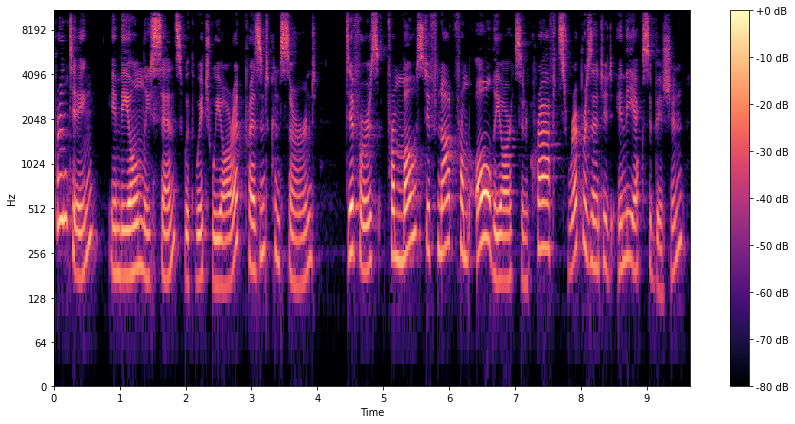

torch.Size([212893]) torch.Size([513, 832]) 22050


In [2]:
y, sr = load('/media/ycy/Shared/Datasets/LJSpeech-1.1/LJSpeech-1.1/wavs/LJ001-0001.wav', sr=None)
y = torch.Tensor(y)#[:sr * 4]

nfft = 1024
hop_length = 256
window = torch.hann_window(nfft)

S = torch.stft(y, nfft, window=window, hop_length=hop_length).pow(2).sum(2).sqrt()

fig = plt.figure(figsize=(12, 6))
display.specshow(librosa.amplitude_to_db(S.numpy(), ref=np.max), y_axis='log', x_axis='time', sr=sr, hop_length=hop_length)
plt.colorbar(format='%+2.0f dB')
plt.tight_layout()
plt.show()

print(y.shape, S.shape, sr)

ipd.Audio(y.numpy(), rate=sr)


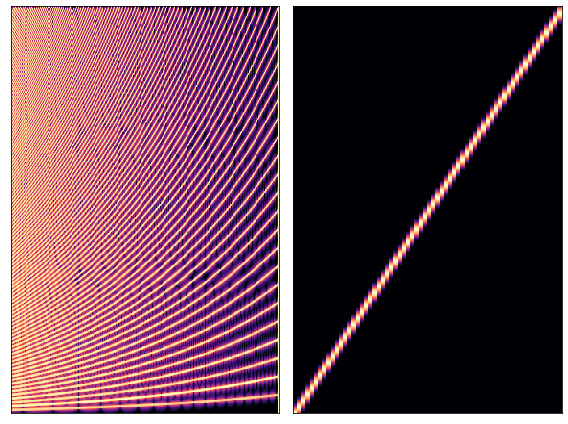

In [5]:
class SourceFilter(nn.Module):
    def __init__(self):
        super().__init__()
        self.Fmin=100
        self.Fmax=500

        
        Ust = 10
        step_size = np.log(2) / 12 / Ust
        self.freqs = np.exp(np.arange(np.log(self.Fmin), np.log(self.Fmax), step_size))
        
        tmp = []
        for f in self.freqs:
            h = np.arange(int(0.5 * sr / f)) + 1
            #h = h[:40]
            ch = f * 27 / 4 * (np.exp(-1j * np.pi * h) + 
                               2 * (1 + 2 * np.exp(-1j * np.pi * h)) / (1j * np.pi * h) - 
                               6 * (1 - np.exp(-1j * np.pi * h)) / (1j * np.pi * h) ** 2)
            ch /= np.abs(ch).max()
            t = np.arange(nfft) / sr
            eu = ch @ np.exp(2j * np.pi * h[:, None] * f * t)
            eu /= np.linalg.norm(eu)
            tmp.append(np.abs(np.fft.fft(eu * window.numpy())[:nfft//2+1]))
            #plt.plot(eu.real)
            #plt.show()
        
        noise = np.ones(nfft // 2 + 1)
        tmp.append(noise)
        
        W_f0 = np.vstack(tmp).T
        W_f0 /= W_f0.max(0)
        
        self.source = NMF(S.shape, W=torch.Tensor(W_f0), rank=W_f0.shape[1], trainable_W=False)

        P = 64
        
        hann_size = int(nfft * 0.5 / (P - 1) * 4)
        tmp_hann = torch.hann_window(hann_size)
        
        W_filt = torch.zeros(nfft // 2 + 1 + hann_size // 2 * 2, P)
        for i in range(P):
            pos = int(i / P * (nfft // 2 + 1))
            W_filt[pos:pos+hann_size, i] = tmp_hann
        W_filt = W_filt[hann_size//2:hann_size//2 + nfft // 2 + 1]
        
        K = 10
        
        self.filt1 = NMF(W=torch.Tensor(W_filt), H=(P, K), trainable_W=False)
        self.filt2 = NMF(H=(K, S.shape[1]))

    def forward(self):
        return selsource() * self.filt2(W=self.filt1())


net = SourceFilter()

fig = plt.figure(figsize=(8, 6))
plt.subplot(121)
display.specshow(librosa.amplitude_to_db(net.source.W.detach().numpy()))
plt.subplot(122)
display.specshow(net.filt1.W.numpy())
plt.tight_layout()
plt.show()

In [6]:
net.train()
net = net.cuda()
Scu = S.cuda()

maxiter = 200
optim = BetaMu(net.parameters(), beta=1)
for i in range(maxiter):
    def closure():
        return Scu, net()
    net.zero_grad()
    optim.step(closure)
    print(i+1, Beta_divergence(net() + 1e-8, Scu + 1e-8, 1).mul(2).sqrt().item())

1 536.195068359375
2 499.6163330078125
3 448.05023193359375
4 377.9798583984375
5 328.693359375
6 305.43719482421875
7 290.055908203125
8 277.4122009277344
9 266.67950439453125
10 257.60296630859375
11 249.94287109375
12 243.47079467773438
13 237.993896484375
14 233.3530731201172
15 229.40806579589844
16 226.02835083007812
17 223.09652709960938
18 220.51565551757812
19 218.21005249023438
20 216.12265014648438
21 214.2113494873047
22 212.4449920654297
23 210.8012237548828
24 209.2639617919922
25 207.82180786132812
26 206.466552734375
27 205.19252014160156
28 203.9954071044922
29 202.87196350097656
30 201.81883239746094
31 200.83241271972656
32 199.90841674804688
33 199.04238891601562
34 198.23037719726562
35 197.46827697753906
36 196.75245666503906
37 196.0793914794922
38 195.44557189941406
39 194.84793090820312
40 194.28338623046875
41 193.7491912841797
42 193.24288940429688
43 192.7621612548828
44 192.304931640625
45 191.8692626953125
46 191.45339965820312
47 191.0557861328125
48 190.

(513, 600)


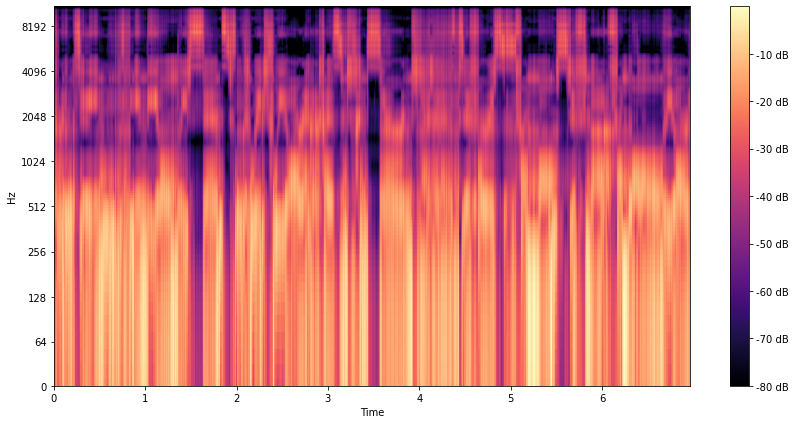

In [12]:
y = net.filt2(W=net.filt1()).detach().cpu().numpy()[:, :600]
#y = net.impulse.squeeze().detach().cpu().numpy()[:, :200]
#y /= y.max(0)
print(y.shape)

fig = plt.figure(figsize=(12, 6))
display.specshow(librosa.amplitude_to_db(y, ref=np.max), y_axis='log', x_axis='time', sr=sr, hop_length=hop_length)
plt.colorbar(format='%+2.0f dB')
plt.tight_layout()
plt.show()